In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 2000

betas = [ 0.001, 0.005, 0.0001, 0.0005]

#  $m=n=1000$

In [4]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4881e-01, fro_norm=7.0724e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4729e-01, fro_norm=7.0803e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=2.9665e-02, fro_norm=2.8111e-01
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=2.9787e-02, fro_norm=2.7990e-01
lamb_max=3.7620e+00


In [5]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter)

lamb_max=3.7620e+00
lamb_max=10.007453778397428
obj (diag scaling):  -0.9927147626876831 
constraint viol (diag scaling):  0.1495599756017327
lamb_max=10.007453778397428
obj (vanilla):  -0.9866081476211548 
constraint viol (vanilla):  0.1988519690930843
lamb_max=10.007453778397428
obj (acceleration):  -0.9866081476211548 
constraint viol (acceleration):  0.1988519690930843
lamb_max=3.7620e+00
lamb_max=10.007453778397428
obj (diag scaling):  -4.814376354217529 
constraint viol (diag scaling):  0.054558437317609766
lamb_max=10.007453778397428
obj (vanilla):  -4.683651924133301 
constraint viol (vanilla):  0.06718111783266065
lamb_max=10.007453778397428
obj (acceleration):  -4.683651924133301 
constraint viol (acceleration):  0.06718111783266065
lamb_max=3.7620e+00
lamb_max=10.007453778397428
obj (diag scaling):  -0.09993162751197815 
constraint viol (diag scaling):  1.407674037385732
lamb_max=10.007453778397428
obj (vanilla):  -0.09989725053310394 
constraint viol (vanilla):  1.695951552

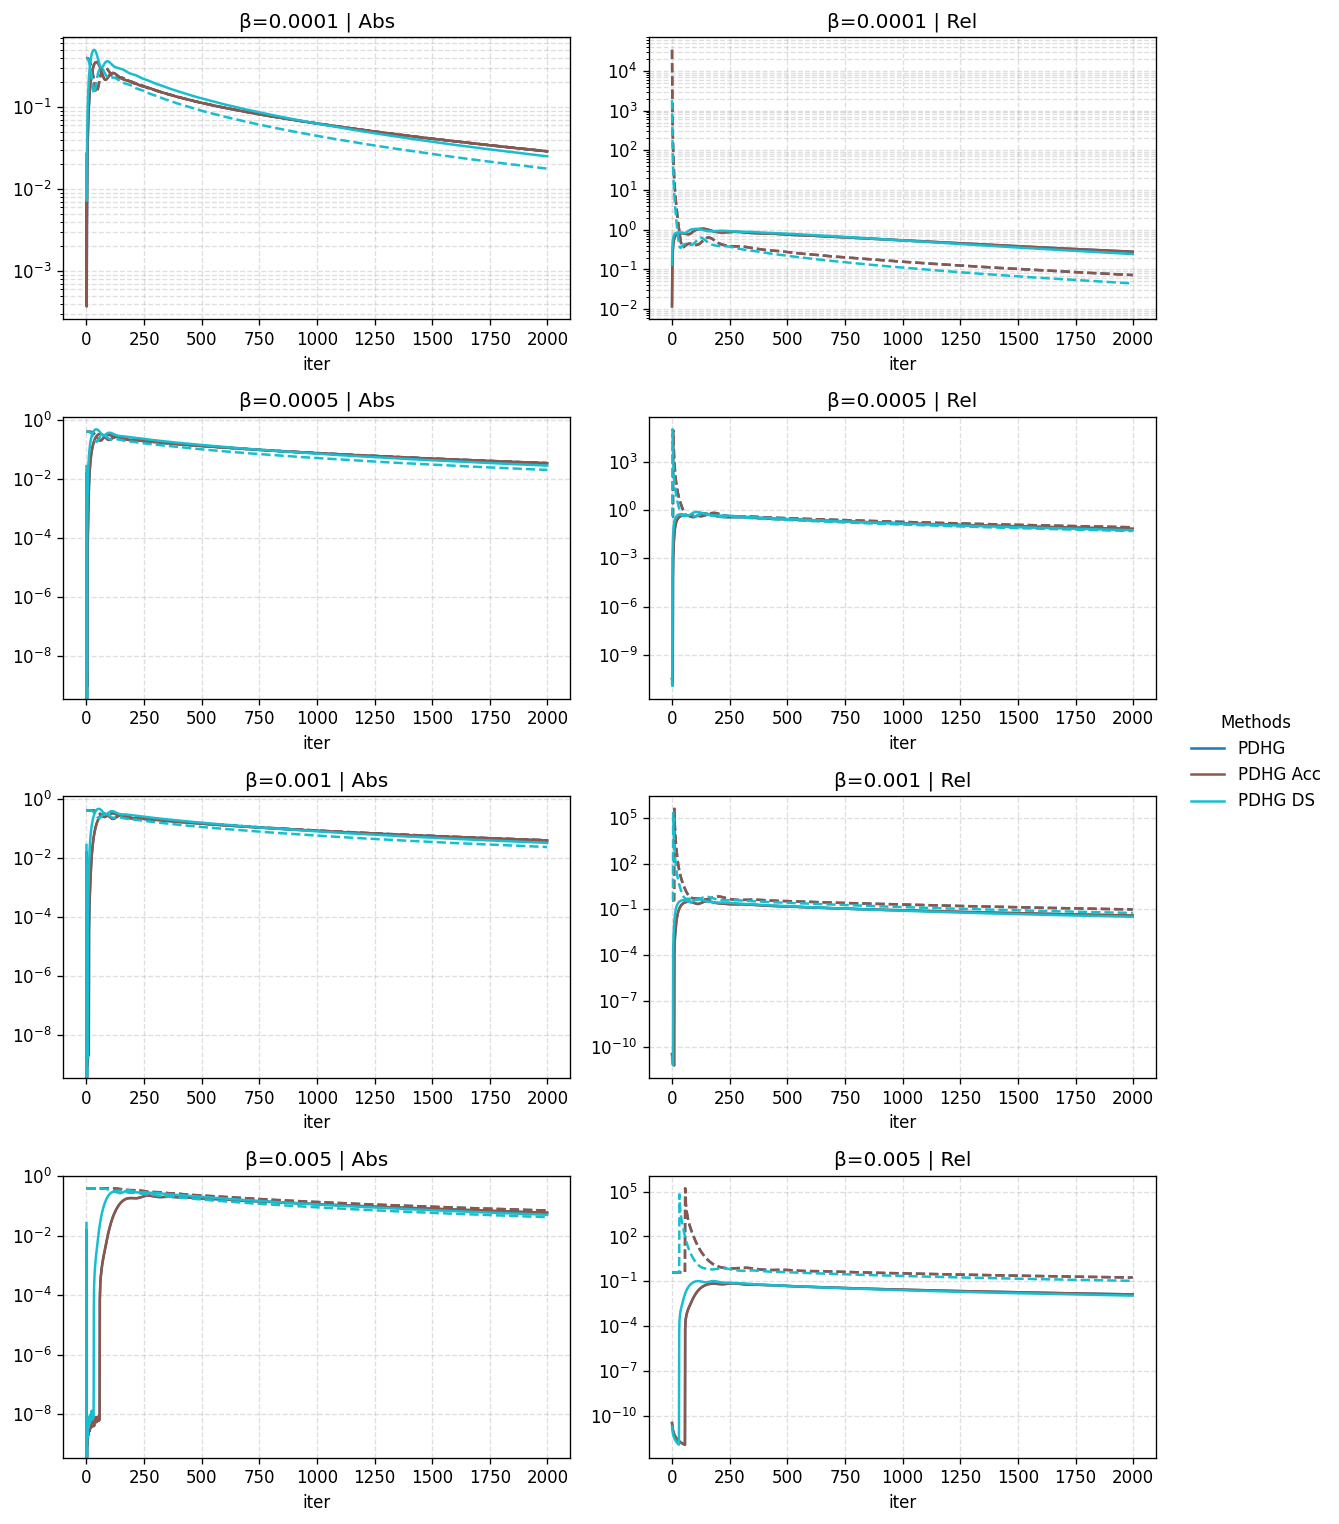

In [6]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [7]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4415e-01, fro_norm=7.0653e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4532e-01, fro_norm=7.0719e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=2.9475e-03, fro_norm=2.8003e-02


A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=2.9528e-03, fro_norm=2.8002e-02
mu_reg=0.0000e+00, lamb_max=9.9966e+00


In [8]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter)

lamb_max=9.9966e+00
lamb_max=9.99656426071184
obj (diag scaling):  -0.0929267480969429 
constraint viol (diag scaling):  0.04275159537792204
lamb_max=9.99656426071184
obj (vanilla):  -0.08817183971405029 
constraint viol (vanilla):  0.04797095991671083
lamb_max=9.99656426071184
obj (acceleration):  -0.08817183971405029 
constraint viol (acceleration):  0.04797095991671083
lamb_max=9.9966e+00
lamb_max=9.99656426071184
obj (diag scaling):  -0.3562019467353821 
constraint viol (diag scaling):  0.025842968374490717
lamb_max=9.99656426071184
obj (vanilla):  -0.274537593126297 
constraint viol (vanilla):  0.03151462972164152
lamb_max=9.99656426071184
obj (acceleration):  -0.274537593126297 
constraint viol (acceleration):  0.03151462972164152
lamb_max=9.9966e+00
lamb_max=9.99656426071184
obj (diag scaling):  -0.009927120991051197 
constraint viol (diag scaling):  0.16149210953153664
lamb_max=9.99656426071184
obj (vanilla):  -0.00986756756901741 
constraint viol (vanilla):  0.1902784171979873

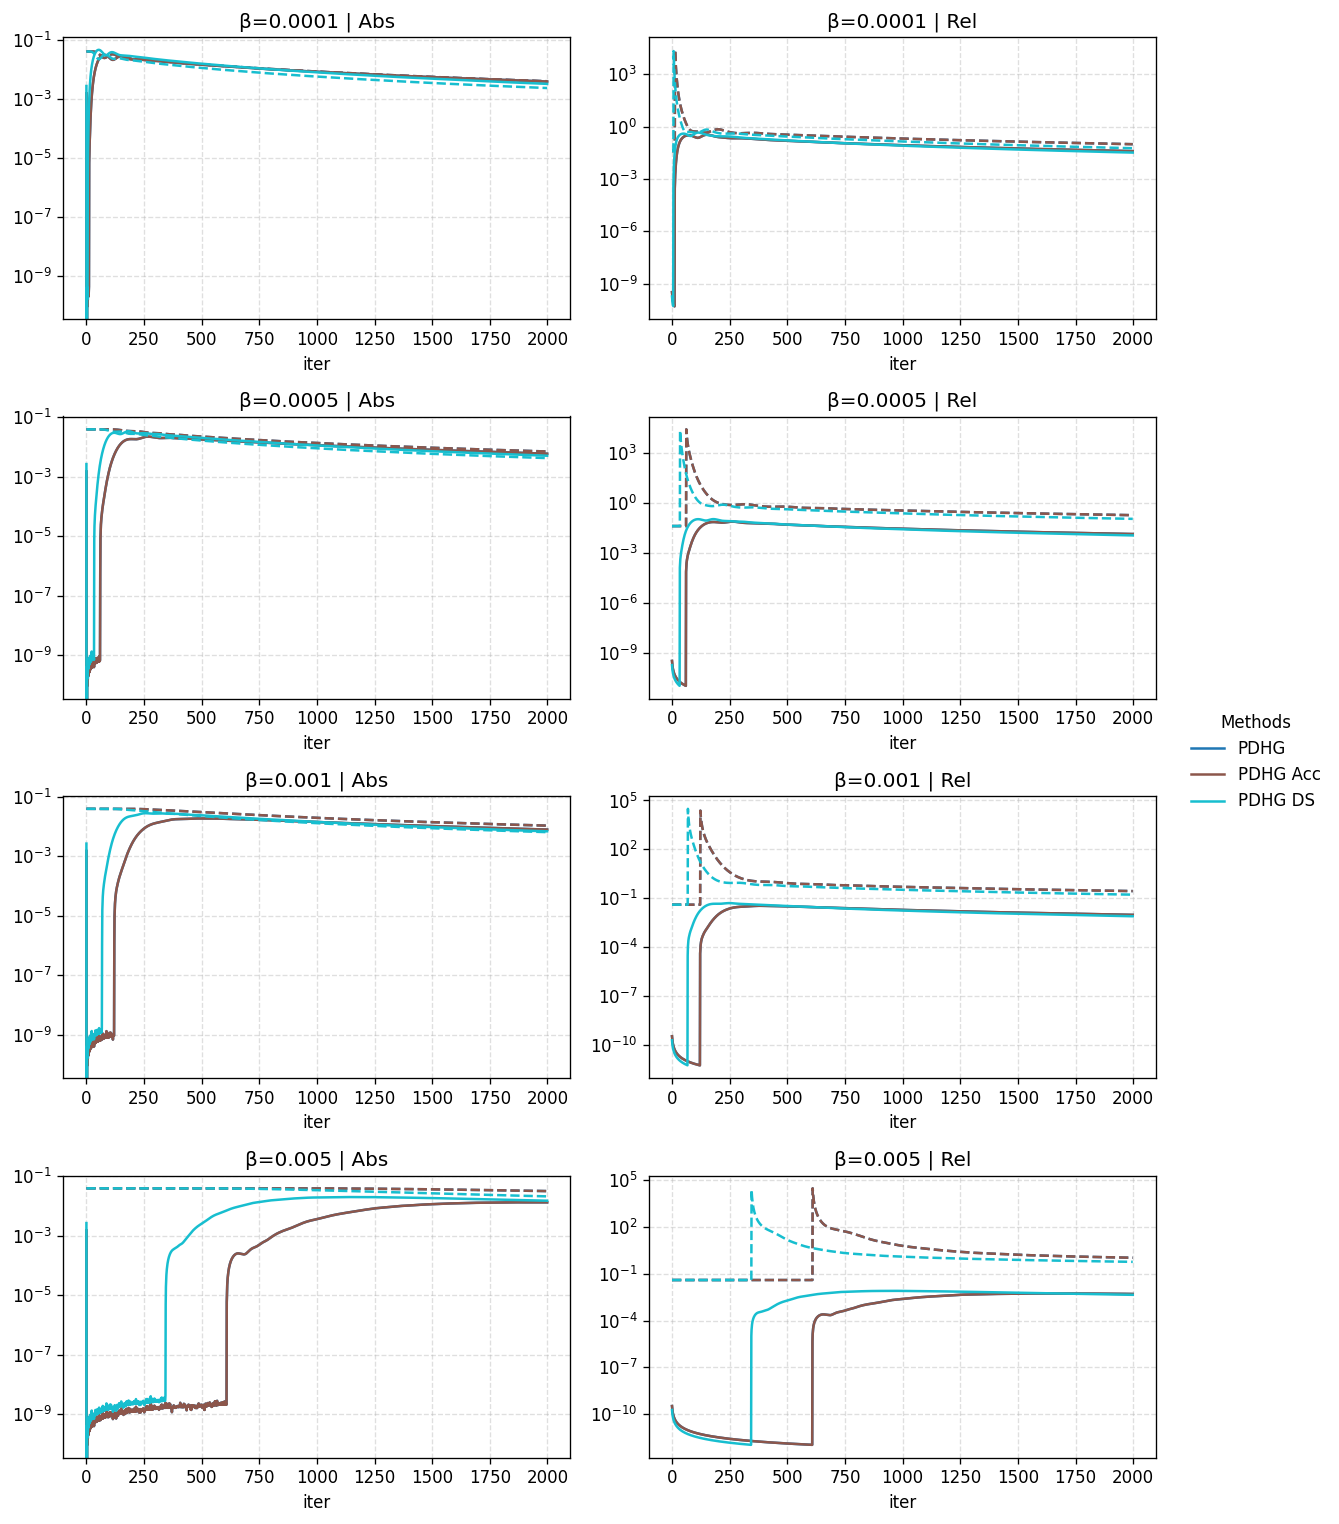

In [9]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')